In [1]:
import pandas as pd  
import numpy as np    
import matplotlib as plt 
import seaborn as sns 


In [3]:
uber_data = pd.read_csv('uber.csv')


In [5]:
data_overview = {
    "Shape of the dataset": uber_data.shape,
    "Column Names": uber_data.columns.tolist(),
    "Data Types": uber_data.dtypes.to_dict(),
    "First Few Rows": uber_data.head()
}

data_overview

{'Shape of the dataset': (200000, 9),
 'Column Names': ['Unnamed: 0',
  'key',
  'fare_amount',
  'pickup_datetime',
  'pickup_longitude',
  'pickup_latitude',
  'dropoff_longitude',
  'dropoff_latitude',
  'passenger_count'],
 'Data Types': {'Unnamed: 0': dtype('int64'),
  'key': dtype('O'),
  'fare_amount': dtype('float64'),
  'pickup_datetime': dtype('O'),
  'pickup_longitude': dtype('float64'),
  'pickup_latitude': dtype('float64'),
  'dropoff_longitude': dtype('float64'),
  'dropoff_latitude': dtype('float64'),
  'passenger_count': dtype('int64')},
 'First Few Rows':    Unnamed: 0                            key  fare_amount  \
 0    24238194    2015-05-07 19:52:06.0000003          7.5   
 1    27835199    2009-07-17 20:04:56.0000002          7.7   
 2    44984355   2009-08-24 21:45:00.00000061         12.9   
 3    25894730    2009-06-26 08:22:21.0000001          5.3   
 4    17610152  2014-08-28 17:47:00.000000188         16.0   
 
            pickup_datetime  pickup_longitude  p

In [7]:
missing_values = uber_data.isnull().sum()
summary_statistics = uber_data.describe()
missing_values, summary_statistics

(Unnamed: 0           0
 key                  0
 fare_amount          0
 pickup_datetime      0
 pickup_longitude     0
 pickup_latitude      0
 dropoff_longitude    1
 dropoff_latitude     1
 passenger_count      0
 dtype: int64,
          Unnamed: 0    fare_amount  pickup_longitude  pickup_latitude  \
 count  2.000000e+05  200000.000000     200000.000000    200000.000000   
 mean   2.771250e+07      11.359955        -72.527638        39.935885   
 std    1.601382e+07       9.901776         11.437787         7.720539   
 min    1.000000e+00     -52.000000      -1340.648410       -74.015515   
 25%    1.382535e+07       6.000000        -73.992065        40.734796   
 50%    2.774550e+07       8.500000        -73.981823        40.752592   
 75%    4.155530e+07      12.500000        -73.967154        40.767158   
 max    5.542357e+07     499.000000         57.418457      1644.421482   
 
        dropoff_longitude  dropoff_latitude  passenger_count  
 count      199999.000000     199999.0

In [9]:
uber_data_cleaned = uber_data.dropna()
print("Missing values after cleaning:", uber_data_cleaned.isnull().sum())

Missing values after cleaning: Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [11]:
uber_data_cleaned = uber_data_cleaned[(uber_data_cleaned['fare_amount'] > 0) & 
                                      (uber_data_cleaned['fare_amount'] <= 200)]

In [13]:
valid_lat = (uber_data_cleaned['pickup_latitude'].between(-90, 90)) & \
            (uber_data_cleaned['dropoff_latitude'].between(-90, 90))
valid_lon = (uber_data_cleaned['pickup_longitude'].between(-180, 180)) & \
            (uber_data_cleaned['dropoff_longitude'].between(-180, 180))
uber_data_cleaned = uber_data_cleaned[valid_lat & valid_lon]

In [15]:
uber_data_cleaned = uber_data_cleaned[(uber_data_cleaned['passenger_count'] > 0) & 
                                      (uber_data_cleaned['passenger_count'] <= 6)]

In [17]:
uber_data_cleaned['pickup_datetime'] = pd.to_datetime(uber_data_cleaned['pickup_datetime'])
uber_data_cleaned['pickup_hour'] = uber_data_cleaned['pickup_datetime'].dt.hour
uber_data_cleaned['pickup_day'] = uber_data_cleaned['pickup_datetime'].dt.day
uber_data_cleaned['pickup_month'] = uber_data_cleaned['pickup_datetime'].dt.month
uber_data_cleaned['pickup_year'] = uber_data_cleaned['pickup_datetime'].dt.year

In [19]:
!pip install geopy
from geopy.distance import geodesic
def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(pickup, dropoff).km
uber_data_cleaned['trip_distance_km'] = uber_data_cleaned.apply(calculate_distance, axis=1)

Defaulting to user installation because normal site-packages is not writeable


In [21]:
from sklearn.model_selection import train_test_split

features = uber_data_cleaned[['trip_distance_km', 'pickup_hour', 'pickup_day', 
                               'pickup_month', 'pickup_year', 'passenger_count']]
target = uber_data_cleaned['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [23]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

MAE: 5.965913218645471, MSE: 93.31583300704345, RMSE: 9.660012060398447
R² Score: 0.015022713984899516


In [27]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}


results = {}
for model_name, model in models.items():
   
    model.fit(X_train, y_train)
    
    y_pred_model = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred_model)
    mse = mean_squared_error(y_test, y_pred_model)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred_model)
    
    results[model_name] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by="R²", ascending=False)


,MAE,MSE,RMSE,R²
Gradient Boosting,2.216255,22.282866,4.720473,0.764798
Random Forest,2.393929,24.668508,4.966740,0.739616
XGBoost,2.315372,27.132921,5.208927,0.713604
Decision Tree,3.263503,49.016530,7.001181,0.482615
Linear Regression,5.965913,93.315833,9.660012,0.015023


In [31]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': np.arange(100, 301, 50),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_dist,
    scoring='neg_mean_absolute_error',
    n_iter=20,  # Number of random combinations to test
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Convert to positive
print("Best Parameters:", best_params)
print("Best MAE:", best_score)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 250, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.05}
Best MAE: 2.187402483017015


In [32]:
final_model = GradientBoostingRegressor(
    n_estimators=250,
    min_samples_split=5,
    min_samples_leaf=4,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)

final_model.fit(X_train, y_train)
final_y_pred = final_model.predict(X_test)
final_mae = mean_absolute_error(y_test, final_y_pred)
final_mse = mean_squared_error(y_test, final_y_pred)
final_rmse = final_mse ** 0.5
final_r2 = r2_score(y_test, final_y_pred)
print(f"Final MAE: {final_mae}")
print(f"Final MSE: {final_mse}")
print(f"Final RMSE: {final_rmse}")
print(f"Final R²: {final_r2}")

Final MAE: 2.1928612141312693
Final MSE: 22.013900544485026
Final RMSE: 4.691897328851626
Final R²: 0.7676365166104603


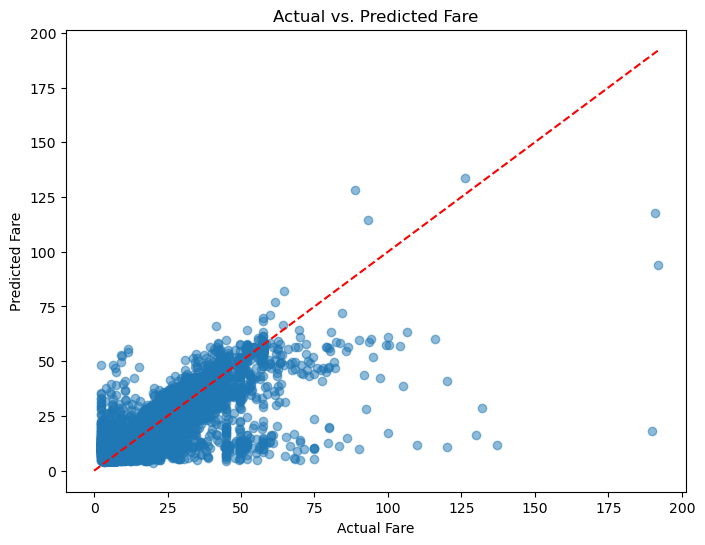

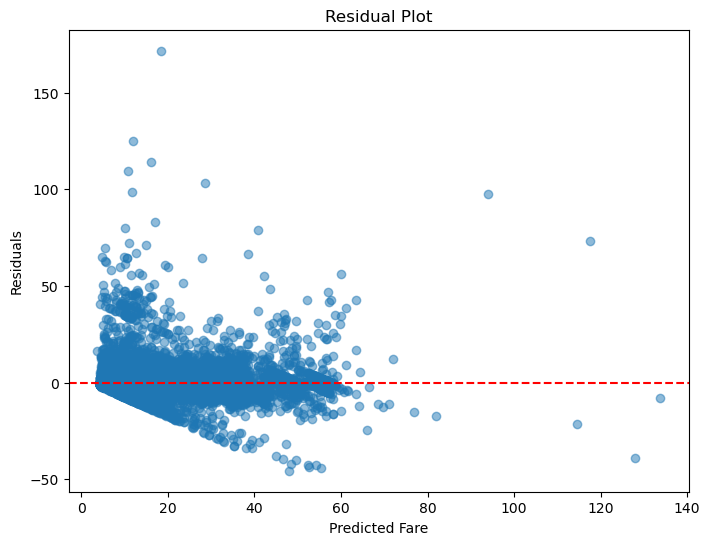

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_y_pred, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs. Predicted Fare")
plt.show()
residuals = y_test - final_y_pred
plt.figure(figsize=(8, 6))
plt.scatter(final_y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Fare")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [37]:
import joblib
model_file_path = 'uber_gradient_boosting_model.pkl'
joblib.dump(final_model, model_file_path)

model_file_path

'uber_gradient_boosting_model.pkl'